Today, we'll build an AI-powered user research system that can automatically generate user personas, conduct interviews, and synthesize insights using LangGraph's multi-agent workflow in under 60 seconds.

For this workshop, you'll need:
- Cerebras API: the fastest inference provider, [get started for free here](https://cloud.cerebras.ai?utm_source=langchainworkshop)
- LangGraph: for orchestrating multi-agent workflows

If you would like to add tracing and evaluation (not required to get started):
- LangSmith: for tracing and evalutating agents, [free signup here](https://smith.langchain.com/?utm_medium=partner&utm_source=cerebras&utm_campaign=q3-2025_cerebras-workshop_co)

If you have any questions, please reach out on the [Cerebras Discord](https://cerebras.ai/discord)


## Step #1: Environment Setup
First, let's install all the necessary libraries, import everything we need, and configure our API credentials.


In [ ]:
%pip install langchain langgraph langchain-openai cerebras-cloud-sdk langchain_cerebras

import logging
import sys
from typing import Dict, List, TypedDict
import time
import os, getpass
from IPython.display import Image, display

from langchain_cerebras import ChatCerebras
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, END

# Configuration Constants
DEFAULT_NUM_INTERVIEWS = 10
DEFAULT_NUM_QUESTIONS = 5

In [ ]:
os.environ["CEREBRAS_API_KEY"]="csk-99k6tptdvethm46ey345fcvvpn3k55thcdjk9c9dj2r4e622"
os.environ["LANGSMITH_TRACING"] = "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"  # Your Langsmith api key if you want to enable tracing
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-cerebras"

# Step #2: Setting up our LLM
These functions sends prompts to llama3.3-70b running on Cerebras and return clean, direct responses. It will serve as our core communication layer throughout the research process - from generating interview questions to creating participant personas to analyzing simulated responses.

In [ ]:
from langchain_cerebras import ChatCerebras

prompt = f"""Generate exactly 3 interview questions about: model context protocol

Requirements:
- Each question must be open-ended (not yes/no)
- Keep questions conversational and clear
- One question per line
- No numbering, bullets, or extra formatting

Topic: model context protocol"""

# Results
llm = ChatCerebras(model="llama3.3-70b",temperature=0.7,max_tokens=800)
response = llm.invoke([{"role": "user", "content": f"You are a helpful assistant. Provide a direct, clear response without showing your thinking process {prompt}"}])
response.pretty_print()

================================== Ai Message ==================================

How do you think understanding the context in which a model is being used can impact the effectiveness of the model context protocol in real-world applications?
What are some potential challenges or limitations that you've encountered when implementing a model context protocol, and how have you addressed them?
Can you describe a situation where a model context protocol was used to improve the performance or reliability of a machine learning model, and what was the outcome of that effort?


In [ ]:
# General model instructions
system_prompt = """You are a helpful assistant. Provide a direct, clear response without showing your thinking process. Respond directly without using <think> tags or showing internal reasoning."""

def ask_ai(prompt: str) -> str:
    """Send prompt to Cerebras AI and return response"""

    response = llm.invoke([{"role":"system", "content": system_prompt},{"role": "user", "content": prompt}])
    return response.content

print("✅ Setup complete")


✅ Setup complete


## Step #3: Define State

Today, we'll be using LangGraph to orchestrate our multi-agent research workflow. LangGraph uses state to coordinate between different nodes, acting as shared memory where each specialized agent can store and access information throughout the process.

We start by defining data classes we will use and a TypedDict that specifies exactly what data our workflow needs to track - from the initial research question all the way through to the final synthesized insights.



In [ ]:
from typing import List
from pydantic import BaseModel, Field, ValidationError

class Persona(BaseModel):
    name: str = Field(..., description="Full name of the persona")
    age: int = Field(..., description="Age in years")
    job: str = Field(..., description="Job title or role")
    traits: List[str] = Field(..., description="3-4 personality traits")
    communication_style: str = Field(..., description="How this person communicates")
    background: str = Field(..., description="One background detail shaping their perspective")

class PersonasList(BaseModel):
    personas: List[Persona] = Field(..., description="List of generated personas")

class InterviewState(TypedDict):
    # Configuration inputs
    research_question: str
    target_demographic: str
    num_interviews: int
    num_questions: int

    # Generated data
    interview_questions: List[str]
    personas: List[Persona]

    # Current interview tracking
    current_persona_index: int
    current_question_index: int
    current_interview_history: List[Dict]

    # Results storage
    all_interviews: List[Dict]
    synthesis: str

print("✅ State management ready")

✅ State management ready


## Step #4: Define Core Node Functions

Next, we'll build the core nodes that handle each part of our research process. Each node is a specialized agent that performs one specific task and updates the shared state for other nodes to use.

In this step, we'll create four main nodes:
1. Configuration node: gets research question from the user
2. Persona generation node: creates synthetic users
3. Interview node: conducts our interviews
4. Synthesis node: analyzes and present results


Configuration Node - Entry point that gathers research parameters and generates questions

In [ ]:
from pydantic import BaseModel, Field

class Questions(BaseModel):
    questions: List = Field(..., description="List of interview questions")

# Generate interview questions using AI
question_gen_prompt = """Generate exactly {DEFAULT_NUM_QUESTIONS} interview questions about: {research_question}. Use the provided structured output to format the questions."""

def configuration_node(state: InterviewState) -> Dict:
    """Get user inputs and generate interview questions"""

    print(f"\n🔧 Configuring research: {state['research_question']}")
    print(f"📊 Planning {DEFAULT_NUM_INTERVIEWS} interviews with {DEFAULT_NUM_QUESTIONS} questions each")

    structured_llm = llm.with_structured_output(Questions)
    questions = structured_llm.invoke(question_gen_prompt.format(DEFAULT_NUM_QUESTIONS=DEFAULT_NUM_QUESTIONS,research_question=state['research_question']))
    questions = questions.questions
    print(f"✅ Generated {len(questions)} questions")

    return {
        "num_questions": DEFAULT_NUM_QUESTIONS,
        "num_interviews": DEFAULT_NUM_INTERVIEWS,
        "interview_questions": questions
    }

Persona Generation Node - Creates diverse user profiles matching the target demographic

In [ ]:
persona_prompt = (
         "Generate exactly {num_personas} unique personas for an interview. "
         "Each should belong to the target demographic: {demographic}. "
         "Respond only in JSON using this format: {{ personas: [ ... ] }}"
     )

def persona_generation_node(state: InterviewState) -> Dict:

    num_personas = state['num_interviews']
    demographic  = state['target_demographic']
    max_retries = 5

    print(f"\n👥 Creating {state['num_interviews']} personas...")

    print(persona_prompt.format(num_personas=num_personas, demographic=demographic))

    structured_llm = llm.with_structured_output(PersonasList)

    for attempt in range(max_retries):
        try:
            raw_output = structured_llm.invoke([{"role": "user", "content": persona_prompt.format(num_personas=num_personas, demographic=demographic)}])
            if raw_output is None:
                raise ValueError("LLM returned None")

            validated = PersonasList.model_validate(raw_output)

            if len(validated.personas) != num_personas:
                raise ValueError(f"Expected {num_personas} personas, got {len(validated.personas)}")

            personas = validated.personas
            for i, p in enumerate(personas):
                print(f"Persona {i+1}: {p}")

            return {
                "personas": personas,
                "current_persona_index": 0,
                "current_question_index": 0,
                "all_interviews": []
            }

        except (ValidationError, ValueError, TypeError) as e:
            print(f"❌ Attempt {attempt+1} failed: {e}")
            print(raw_output)
            if attempt == max_retries - 1:
                raise RuntimeError(f"❗️Failed after {max_retries} attempts")


Interview Node - Conducts the actual Q&A with each persona, one question at a time

In [ ]:
# Generate response as this persona with detailed character context
interview_prompt = """You are {persona_name}, a {persona_age}-year-old {persona_job} who is {persona_traits}.
Answer the following question in 2-3 sentences:

Question: {question}

Answer as {persona_name} in your own authentic voice. Be brief but creative and unique, and make each answer conversational.
BE REALISTIC – do not be overly optimistic. Mimic real human behavior based on your persona, and give honest answers."""

def interview_node(state: InterviewState) -> Dict:
    """Conduct interview with current persona"""
    persona = state['personas'][state['current_persona_index']]
    question = state['interview_questions'][state['current_question_index']]

    print(f"\n💬 Interview {state['current_persona_index'] + 1}/{len(state['personas'])} - {persona.name}")
    print(f"Q{state['current_question_index'] + 1}: {question}")

    # Generate response as this persona with detailed character context
    prompt = interview_prompt.format(persona_name=persona.name,persona_age=persona.age, persona_job=persona.job, persona_traits=persona.traits, question=question)
    answer = ask_ai(prompt)
    print(f"A: {answer}")

    # Update state with interview history
    history = state.get('current_interview_history', []) + [{
        "question": question,
        "answer": answer
    }]

    # Check if this interview is complete
    if state['current_question_index'] + 1 >= len(state['interview_questions']):
        # Interview complete - save it and move to next persona
        return {
            "all_interviews": state['all_interviews'] + [{
                'persona': persona,
                'responses': history
            }],
            "current_interview_history": [],
            "current_question_index": 0,
            "current_persona_index": state['current_persona_index'] + 1
        }

    # Continue with next question for same persona
    return {
        "current_interview_history": history,
        "current_question_index": state['current_question_index'] + 1
    }


Synthesis Node - Analyzes all completed interviews and generates actionable insights

In [ ]:
synthesis_prompt_template = """Analyze these {num_interviews} user interviews about "{research_question}" among {target_demographic} and concise yet comprehensive analysis:

1. KEY THEMES: What patterns and common themes emerged across all interviews? Look for similarities in responses, shared concerns, and recurring topics.

2. DIVERSE PERSPECTIVES: What different viewpoints or unique insights did different personas provide? Highlight contrasting opinions or approaches.

3. PAIN POINTS & OPPORTUNITIES: What challenges, frustrations, or unmet needs were identified? What opportunities for improvement emerged?

4. ACTIONABLE RECOMMENDATIONS: Based on these insights, what specific actions should be taken? Provide concrete, implementable suggestions.

Keep the analysis thorough but well-organized and actionable.

Interview Data:
{interview_summary}
"""

def synthesis_node(state: InterviewState) -> Dict:
    """Synthesize insights from all interviews"""
    print("\n🧠 Analyzing all interviews...")

    # Compile all responses in a structured format
    interview_summary = f"Research Question: {state['research_question']}\n"
    interview_summary += f"Target Demographic: {state['target_demographic']}\n"
    interview_summary += f"Number of Interviews: {len(state['all_interviews'])}\n\n"

    for i, interview in enumerate(state['all_interviews'], 1):
        p = interview['persona']
        interview_summary += f"Interview {i} - {p.name} ({p.age}, {p.job}):\n"
        interview_summary += f"Persona Traits: {p.traits}\n"
        for j, qa in enumerate(interview['responses'], 1):
            interview_summary += f"Q{j}: {qa['question']}\n"
            interview_summary += f"A{j}: {qa['answer']}\n"
        interview_summary += "\n"

    prompt = synthesis_prompt_template.format(
        num_interviews=len(state['all_interviews']),
        research_question=state['research_question'],
        target_demographic=state['target_demographic'],
        interview_summary=interview_summary
    )

    try:
        synthesis = ask_ai(prompt)
    except Exception as e:
        synthesis = f"Error during synthesis: {e}\n\nRaw interview data available for manual analysis."

    # Display results with better formatting
    print("\n" + "="*60)
    print("🎯 COMPREHENSIVE RESEARCH INSIGHTS")
    print("="*60)
    print(f"Research Topic: {state['research_question']}")
    print(f"Demographic: {state['target_demographic']}")
    print(f"Interviews Conducted: {len(state['all_interviews'])}")
    print("-"*60)
    print(synthesis)
    print("="*60)

    return {"synthesis": synthesis}

print("✅ Core nodes ready")


✅ Core nodes ready


## Step #4: Interview Router

This router function determines the next step of our workflow. It decides whether to continue interviewing the current persona, move to the next persona, or end the process and synthesize results.

The router checks our current progress and directs the workflow accordingly - this is what makes LangGraph powerful for complex multi-step processes.


In [ ]:
def interview_router(state: InterviewState) -> str:
    """Route between continuing interviews or ending"""
    if state['current_persona_index'] >= len(state['personas']):
        return "synthesize"
    else:
        return "interview"

print("✅ Router ready")

✅ Router ready


## Step #5: Build LangGraph Workflow

Now we'll connect all our nodes into a complete workflow using LangGraph. This creates a multi-agent system where each node specializes in one task, and the router intelligently manages the flow between them.

The workflow follows this path: Configuration → Persona Generation → Interview Loop → Synthesis

In [ ]:
def build_interview_workflow():
    """Build the complete interview workflow graph"""
    workflow = StateGraph(InterviewState)

    # Add all our specialized nodes
    workflow.add_node("config", configuration_node)
    workflow.add_node("personas", persona_generation_node)
    workflow.add_node("interview", interview_node)
    workflow.add_node("synthesize", synthesis_node)

    # Define the workflow connections
    workflow.set_entry_point("config")
    workflow.add_edge("config", "personas")
    workflow.add_edge("personas", "interview")

    # Conditional routing based on interview progress
    workflow.add_conditional_edges(
        "interview",
        interview_router,
        {
            "interview": "interview",    # Continue interviewing
            "synthesize": "synthesize"   # All done, analyze results
        }
    )
    workflow.add_edge("synthesize", END)

    return workflow.compile()

print("✅ Workflow builder ready")

✅ Workflow builder ready


## Step #6: Run the Complete System

This is the main function that executes our entire LangGraph workflow. It initializes the state, runs the multi-agent system, and delivers comprehensive user research insights.

The workflow automatically handles the complex orchestration between configuration, persona generation, interviews, and synthesis.


✅ Complete LangGraph system ready

What research question would you like to explore? is lmnt good for you
What kinds of users would you like to interview? gym bros


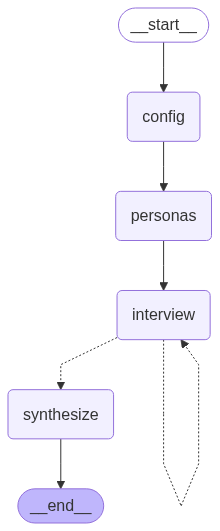


🔧 Configuring research: is lmnt good for you
📊 Planning 10 interviews with 5 questions each
✅ Generated 5 questions

👥 Creating 10 personas...
Generate exactly 10 unique personas for an interview. Each should belong to the target demographic: gym bros. Respond only in JSON using this format: { personas: [ ... ] }
Persona 1: name='Brock Lesnar' age=25 job='Personal Trainer' traits=['confident', 'outgoing', 'competitive', 'disciplined'] communication_style='direct' background='played college football'
Persona 2: name='Hunter Jackson' age=28 job='Gym Owner' traits=['charismatic', 'motivated', 'health-conscious', 'results-driven'] communication_style='enthusiastic' background='former bodybuilder'
Persona 3: name='Ethan Thompson' age=22 job='Fitness Influencer' traits=['ambitious', 'adventurous', 'confident', 'passionate'] communication_style='inspirational' background='started a fitness YouTube channel'
Persona 4: name='Landon Brown' age=29 job='Strength Coach' traits=['intense', 'focused

A: Hydration is key, you know? I've seen LMNT make a real difference for my gym members, especially during intense workouts - it's like a game-changer for replenishing electrolytes. Of course, everyone's body is different, but I've personally noticed a boost in my own performance when I'm using LMNT to stay hydrated.

💬 Interview 2/10 - Hunter Jackson
Q3: What are the benefits of taking LMNT?
A: LMNT is a total game-changer for me and my clients - it's an electrolyte supplement that helps us stay hydrated and perform at our best, even during the toughest workouts. I've noticed a big difference in my endurance and recovery since I started taking it, and I love that it's free of any artificial stuff. It's not a magic pill or anything, but it's definitely a useful tool to have in your fitness arsenal.

💬 Interview 2/10 - Hunter Jackson
Q4: Are there any potential side effects of LMNT?
A: Honestly, I've had clients who've used LMNT and experienced some stomach cramps or bloating, but that'

A: Honestly, I'm a huge fan of LMNT - it's been a game-changer for my hydration and performance. I've noticed a significant difference in my recovery time and overall energy levels since I started using it, and I think it's a great addition to a healthy lifestyle. That being said, it's not a magic bullet - you still need to put in the work and fuel your body with good nutrition and regular exercise.

💬 Interview 3/10 - Ethan Thompson
Q2: Can LMNT help with hydration?
A: Hydration is everything, bro - and I've gotta say, LMNT is a solid choice to help you stay on top of your game. I've tried it myself, and it's definitely helped me replenish those essential electrolytes after a tough workout. Honestly, it's not a magic bullet, but it's a great addition to your hydration routine, especially if you're pushing yourself to the limit like I am.

💬 Interview 3/10 - Ethan Thompson
Q3: What are the benefits of taking LMNT?
A: Honestly, I've been taking LMNT for a while now, and I've noticed a s

A: Honestly, I've seen some great results with LMNT - it's helped my athletes stay hydrated and perform at a higher level, especially during intense training sessions. The electrolyte balance it provides is key, and I've noticed a reduction in cramping and fatigue. It's not a magic bullet, but it's definitely a valuable tool in our training arsenal.

💬 Interview 4/10 - Landon Brown
Q4: Are there any potential side effects of LMNT?
A: Honestly, with LMNT, some people might experience stomach cramps or diarrhea, especially if they're not used to the high electrolyte content. I've seen it happen with a few of my athletes who were new to the product, but it's usually just a matter of their bodies adjusting. It's nothing to be too concerned about, but it's always good to be aware of the potential side effects and start with a small dose to test your tolerance.

💬 Interview 4/10 - Landon Brown
Q5: How does LMNT compare to other hydration supplements?
A: Honestly, I've tried a lot of hydratio

A: So, LMNT is a great supplement for replenishing essential minerals like sodium, potassium, and magnesium. I've seen it be really beneficial for my clients who are super active or sweat a lot, as it helps prevent dehydration and supports healthy electrolyte balance. Overall, it's a solid addition to a healthy routine, but I always recommend talking to a healthcare pro before adding any new supplements.

💬 Interview 5/10 - Cameron Davis
Q4: Are there any potential side effects of LMNT?
A: As a nutritionist, I've seen some clients experience stomach cramps or diarrhea when they first start taking LMNT, likely due to the high electrolyte content. However, these side effects are usually mild and temporary, and most people can adjust to the supplement without any issues. It's also worth noting that people with certain underlying health conditions, like kidney problems, should consult with their doctor before adding LMNT to their routine.

💬 Interview 5/10 - Cameron Davis
Q5: How does LMNT

A: Hydration is a huge part of fitness, and I've seen LMNT make a real difference for some of our gym members. It's not a magic bullet, but it can definitely help top off your electrolytes and support your body's hydration needs, especially after a tough workout. I've tried it myself and can vouch that it's a solid addition to a healthy hydration routine.

💬 Interview 6/10 - Julian Sanchez
Q3: What are the benefits of taking LMNT?
A: Taking LMNT can be a game-changer for our gym members, as it helps replenish essential electrolytes that get depleted during intense workouts. I've seen it make a big difference for people who tend to cramp up or feel fatigued easily, and it's also super convenient to use. Plus, it's pretty affordable and tastes great, which is a bonus!

💬 Interview 6/10 - Julian Sanchez
Q4: Are there any potential side effects of LMNT?


A: Hey, so with LMNT, some people might experience a bit of stomach discomfort or bloating at first, but that's usually just their body adjusting to the new electrolyte balance. I've seen it happen with a few of our gym members who started taking it, but it's pretty rare and typically goes away on its own. Just make sure to drink plenty of water and start with a small dose to test your tolerance, you know?

💬 Interview 6/10 - Julian Sanchez
Q5: How does LMNT compare to other hydration supplements?
A: Honestly, I've tried a few hydration supplements with my gym members and LMNT stands out for its clean ingredients and lack of sugar. It's not a magic bullet, but it does seem to help with recovery and endurance, especially during intense workouts. From what I've seen, it's definitely a solid choice, but everyone's body is different, so it's worth trying out to see how it works for you.

💬 Interview 7/10 - Austin Lee
Q1: Is LMNT good for overall health?
A: LMNT is a solid addition to a hea

A: Honestly, I've had some buddies who've used LMNT and experienced a bit of stomach cramping or diarrhea, probably due to the high electrolyte content. Nothing too crazy, but it's definitely something to be aware of, especially if you're new to using it. I mean, everyone's body is different, so it's all about finding what works for you, you know?

💬 Interview 7/10 - Austin Lee
Q5: How does LMNT compare to other hydration supplements?
A: Honestly, I've tried a bunch of hydration supplements out there, and LMNT is definitely one of the top ones - it's got a solid mix of electrolytes that actually help me recover after a tough leg day. I mean, it's not a miracle worker or anything, but it gets the job done and I like that it's got no artificial stuff or sugar. Compared to some other brands, LMNT is pretty straightforward and effective, no gimmicks or overhyped claims.

💬 Interview 8/10 - Ryan Mitchell
Q1: Is LMNT good for overall health?
A: LMNT is a solid choice for overall health, I've

A: LMNT is definitely a solid choice for overall health, in my opinion. I've seen some of my clients use it to boost their hydration and electrolyte levels, and the results have been pretty positive - they've noticed improvements in their energy levels and workout performance. Of course, everyone's body is different, but I think LMNT can be a great addition to a healthy lifestyle when used properly.

💬 Interview 9/10 - Logan Patel
Q2: Can LMNT help with hydration?
A: Hydration is a huge part of fitness, and I've seen LMNT make a real difference for my clients who struggle to stay hydrated, especially during intense workouts. It's not a magic bullet, but the electrolytes in LMNT can definitely help replenish what's lost in sweat, making it a solid addition to a hydration routine. I recommend giving it a shot, but also listening to your body and adjusting as needed.

💬 Interview 9/10 - Logan Patel
Q3: What are the benefits of taking LMNT?
A: LMNT is a total game-changer - it helps replen

A: Honestly, I've tried a bunch of hydration supplements with my clients, and LMNT stands out for its clean ingredients and effective electrolyte blend. Compared to others, LMNT doesn't have any weird additives or sugars, which I love, and it seems to really help with muscle recovery and hydration, especially after intense workouts. Overall, it's a solid choice, but everyone's body is different, so it's worth trying out to see how it works for you.

💬 Interview 10/10 - Tyler Hall
Q1: Is LMNT good for overall health?
A: LMNT is a solid choice for overall health, in my opinion. As someone who's always pushing their body to the limit, I need something that can keep up, and LMNT's electrolyte blend definitely helps with hydration and recovery. That being said, it's not a magic bullet - you still need to put in the work and fuel your body with a balanced diet to see real results.

💬 Interview 10/10 - Tyler Hall
Q2: Can LMNT help with hydration?
A: Hydration is a top priority for my fitness 

A: Honestly, with LMNT, some people might experience stomach cramps or diarrhea, especially if they're not used to the high dose of electrolytes. I've seen it happen to a few of my clients who jumped in too fast, but it's usually just a matter of adjusting to it. Overall, it's a solid product, but like with anything, you gotta listen to your body and ease into it.

💬 Interview 10/10 - Tyler Hall
Q5: How does LMNT compare to other hydration supplements?
A: Honestly, I've tried a bunch of hydration supplements, and LMNT stands out for its clean ingredients and no-BS approach - it's not just some sugary drink mix. Compared to others, LMNT is more straightforward and effective, without all the extra fluff, which is why I recommend it to my fitness community. It's not a magic pill, but it gets the job done, and that's what I'm about - results.

🧠 Analyzing all interviews...



🎯 COMPREHENSIVE RESEARCH INSIGHTS
Research Topic: is lmnt good for you
Demographic: gym bros
Interviews Conducted: 10
------------------------------------------------------------
**Key Themes:**

1. **Hydration and Electrolyte Balance**: All interviewees agreed that LMNT is effective in replenishing essential electrolytes and supporting hydration, especially during intense workouts.
2. **Performance and Recovery**: Many gym bros reported improved performance and faster recovery when using LMNT, citing reduced muscle cramps and fatigue.
3. **No Magic Bullet**: All interviewees emphasized that LMNT is not a magic bullet and should be used in conjunction with a balanced diet, regular exercise, and proper hydration.
4. **Clean Ingredients and Effective Formula**: LMNT's clean ingredients and effective electrolyte blend were consistently praised by the interviewees.

**Diverse Perspectives:**

1. **Confidence in LMNT**: Brock Lesnar, Hunter Jackson, and Ethan Thompson expressed confidence 

In [ ]:
def run_research_system():
    """Execute the complete LangGraph research workflow"""

    research_question = input("\nWhat research question would you like to explore? ")
    target_demographic = input("What kinds of users would you like to interview? ")

    workflow = build_interview_workflow()

    display(Image(workflow.get_graph(xray=True).draw_mermaid_png()))

    start_time = time.time()

    # Initialize state. This is needed before saving our values later
    initial_state = {
        "research_question": research_question,
        "target_demographic": target_demographic,
        "num_interviews": DEFAULT_NUM_INTERVIEWS,
        "num_questions": DEFAULT_NUM_QUESTIONS,
        "interview_questions": [],
        "personas": [],
        "current_persona_index": 0,
        "current_question_index": 0,
        "current_interview_history": [],
        "all_interviews": [],
        "synthesis": ""
    }

    try:
        final_state = workflow.invoke(initial_state, {"recursion_limit": 100})
        total_time = time.time() - start_time
        print(f"\n✅ Workflow complete! {len(final_state['all_interviews'])} interviews in {total_time:.1f}s")
        return final_state
    except Exception as e:
        print(f"❌ Error during workflow execution: {e}")
        return None

print("✅ Complete LangGraph system ready")
result = run_research_system()

## Tracing and Evaluation
LangSmith is a platform for tracing, monitoring and evaluating your LLM applications. It is very handy when developing applications. It gives you visibility into the flow of data to and from models and nodes of your graph.
The instructions here will help you get started: [Getting Started with LangSmith](https://docs.smith.langchain.com/)

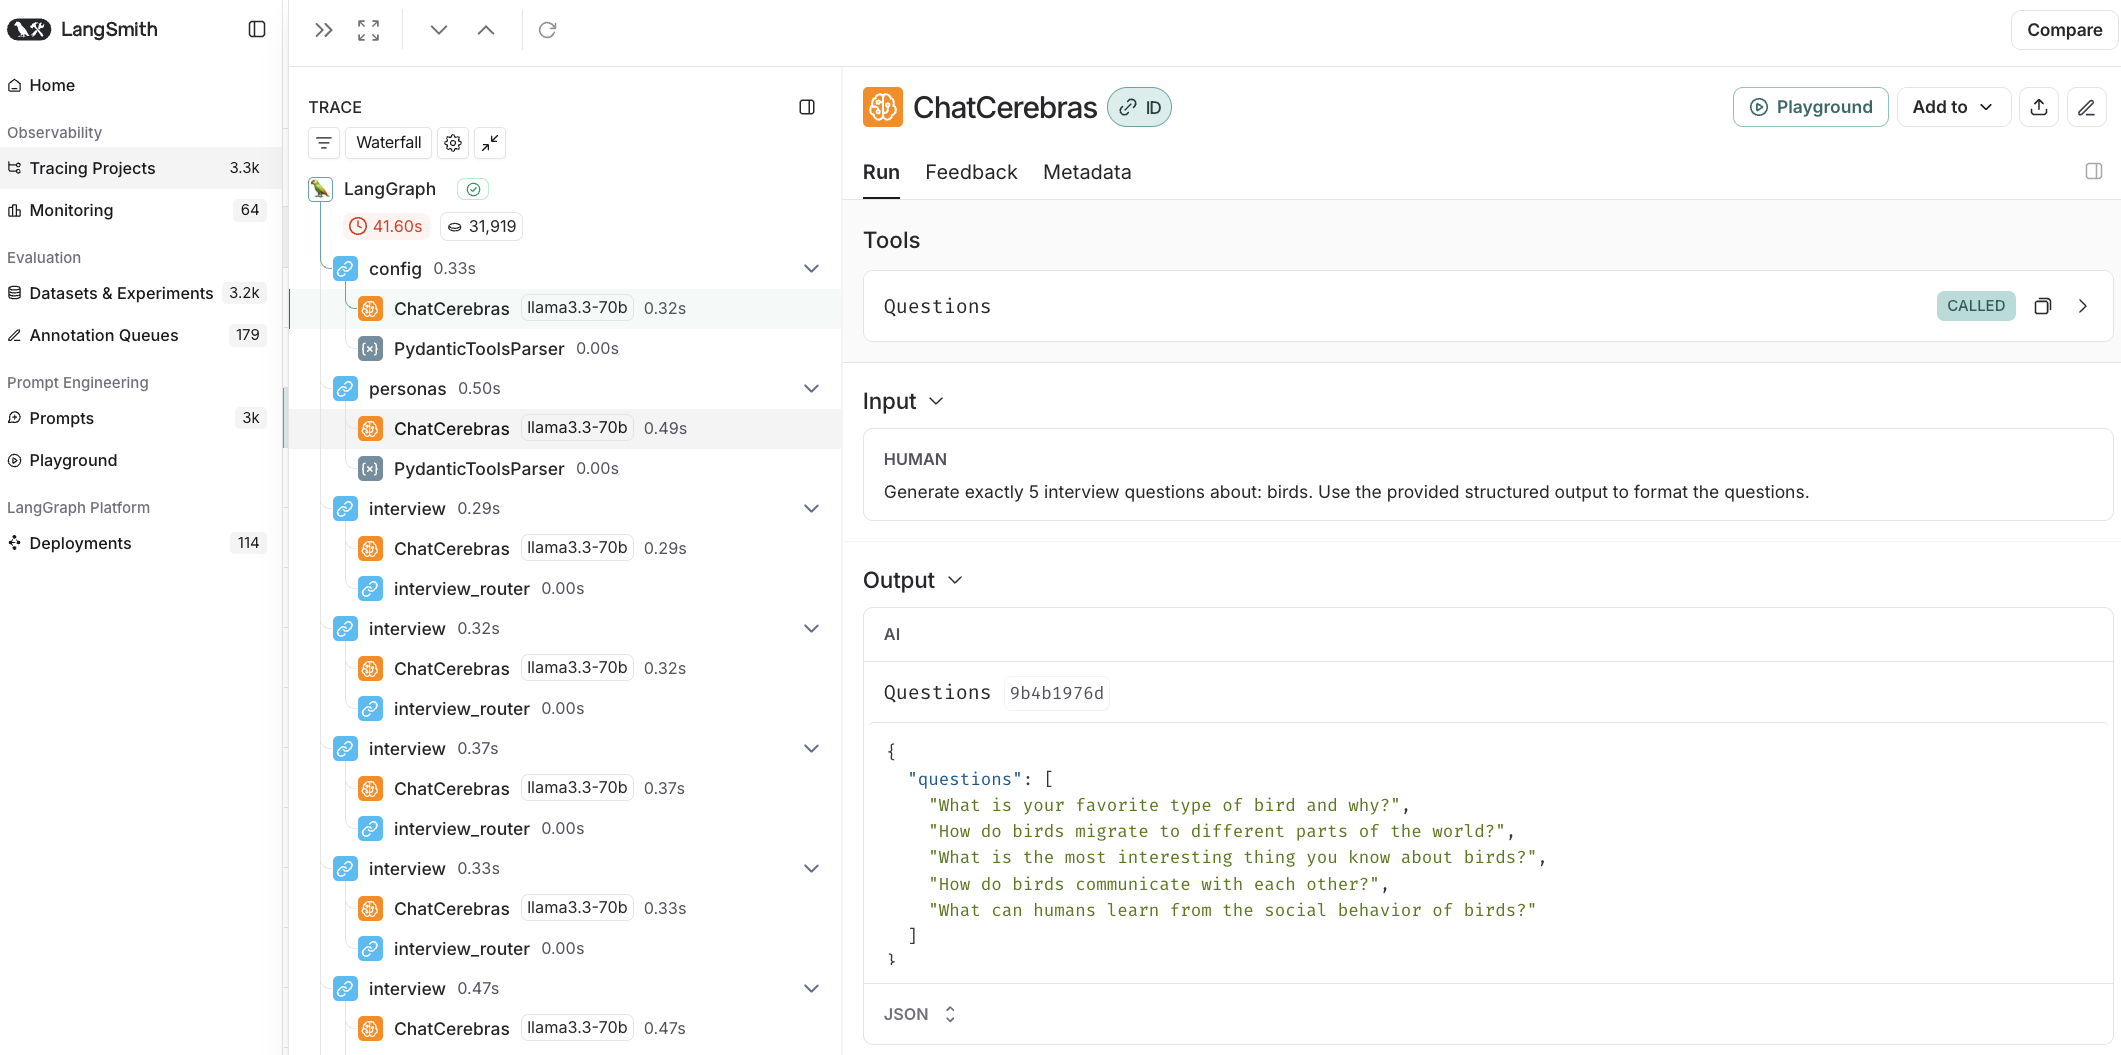

# Optional: Follow Up Question
If you'd like to add a little bit more complexity, we can change our router and create a system for each persona to be asked one follow up question based on their previous answers.

In [ ]:
followup_question_prompt = """
Generate ONE natural follow‑up question for {persona_name} based on their last answer:
"{previous_answer}"
Keep it conversational and dig a bit deeper.
"""

followup_answer_prompt = """
You are {persona_name}, a {persona_age}-year-old {persona_job} who is {persona_traits}.

Answer the follow‑up question below in 2‑4 sentences, staying authentic and specific.

Follow‑up question: {followup_question}

Answer as {persona_name}:
"""

# ── main node ────────────────────────────────────────────────────────────────
def interview_node(state: InterviewState) -> Dict:
    """Conduct interview with current persona (adds a single follow‑up)."""

    persona  = state['personas'][state['current_persona_index']]
    question = state['interview_questions'][state['current_question_index']]

    print(f"\n💬 Interview {state['current_persona_index'] + 1}/{len(state['personas'])} - {persona.name}")
    print(f"Q{state['current_question_index'] + 1}: {question}")

    # main answer
    prompt  = interview_prompt.format(
        persona_name   = persona.name,
        persona_age    = persona.age,
        persona_job    = persona.job,
        persona_traits = persona.traits,
        question       = question
    )
    answer  = ask_ai(prompt)
    print(f"A: {answer}")

    # update history
    history = state.get('current_interview_history', []) + [{
        "question"   : question,
        "answer"     : answer,
        "is_followup": False
    }]

    # ---------- if that was the last main question ----------
    if state['current_question_index'] + 1 >= len(state['interview_questions']):

        # ----- add ONE follow‑up (only if not done already) -----
        if not any(entry.get("is_followup") for entry in history):
            followup_q = ask_ai(
                followup_question_prompt.format(
                    persona_name    = persona.name,
                    previous_answer = answer
                )
            )
            print(f"🔄 Follow‑up: {followup_q}")

            followup_ans = ask_ai(
                followup_answer_prompt.format(
                    persona_name      = persona.name,
                    persona_age       = persona.age,
                    persona_job       = persona.job,
                    persona_traits    = persona.traits,
                    followup_question = followup_q
                )
            )
            print(f"A: {followup_ans}")

            history.append({
                "question"   : followup_q,
                "answer"     : followup_ans,
                "is_followup": True
            })

        # save interview & advance to next persona
        return {
            "all_interviews"         : state['all_interviews'] + [{
                'persona'  : persona,
                'responses': history
            }],
            "current_interview_history": [],
            "current_question_index"   : 0,
            "current_persona_index"    : state['current_persona_index'] + 1
        }

    # ---------- otherwise keep going through main questions ----------
    return {
        "current_interview_history": history,
        "current_question_index"  : state['current_question_index'] + 1
    }


# This won't require running any additional code, as it uses the same graph and router with identicle naming conventions. All that's left is to run it :)


What research question would you like to explore? do we like lmnt
What kinds of users would you like to interview? gym bros


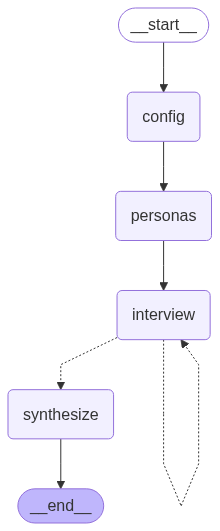


🔧 Configuring research: do we like lmnt
📊 Planning 10 interviews with 5 questions each
✅ Generated 5 questions

👥 Creating 10 personas...
Generate exactly 10 unique personas for an interview. Each should belong to the target demographic: gym bros. Respond only in JSON using this format: { personas: [ ... ] }


Persona 1: name='Brody Jackson' age=25 job='Personal Trainer' traits=['confident', 'outgoing', 'competitive', 'disciplined'] communication_style='direct and assertive' background='played college football'
Persona 2: name='Tyler Mitchell' age=28 job='Fitness Coach' traits=['charismatic', 'motivated', 'adventurous', 'confident'] communication_style='enthusiastic and persuasive' background='ran a marathon last year'
Persona 3: name='Austin Lee' age=22 job='Gym Receptionist' traits=['friendly', 'outgoing', 'energetic', 'curious'] communication_style='bubbly and engaging' background='plays recreational soccer'
Persona 4: name='Ethan Hall' age=29 job='Strength Coach' traits=['intense', 'focused', 'analytical', 'driven'] communication_style='straightforward and results-oriented' background='competed in powerlifting'
Persona 5: name='Landon Brown' age=26 job='Fitness Influencer' traits=['charming', 'ambitious', 'creative', 'confident'] communication_style='charismatic and persuasive' backgroun

A: I'm a huge fan of LMNT, to be honest. As a personal trainer, I need something that's gonna help me replenish those essential minerals after a tough workout, and LMNT does just that - it's like a game-changer for my hydration routine. I've tried other stuff before, but LMNT's the real deal, and I can feel the difference it makes in my performance and recovery.

💬 Interview 1/10 - Brody Jackson
Q3: Have you tried LMNT before?
A: Yeah, I've tried LMNT before - it's a solid hydration supplement, especially after a tough leg day. I've got a buddy who swears by it, so I gave it a shot and it definitely helped with my recovery. Not gonna lie, it's a bit pricey, but it gets the job done.

💬 Interview 1/10 - Brody Jackson
Q4: What do you think about the taste of LMNT?
A: Honestly, I'm not a huge fan of the taste of LMNT, it's a bit too salty for my liking. But hey, as a trainer, I know it's all about getting the right electrolytes in, so I suck it up and deal with it. It's not the worst thin

🔄 Follow‑up: What specifically about LMNT has made the biggest difference for you, is it the hydration, the energy boost, or something else entirely?
A: For me, it's been the hydration aspect of LMNT that's made the biggest difference - I can push myself harder and longer in my workouts without feeling drained or fatigued. The fact that it's got no sugar, no artificial ingredients, and just the right amount of electrolytes has been a game-changer for my training sessions. I've noticed a significant improvement in my endurance and recovery time, which is crucial for someone like me who's always competing with myself to be better. Overall, LMNT has become an essential part of my daily routine, both in and out of the gym.

💬 Interview 2/10 - Tyler Mitchell
Q1: Do you like LMNT?
A: LMNT is a solid choice, I've had it with my clients after a tough workout and it does the job, you know, replenishes those essential minerals. I'm not gonna lie, I've had my fair share of it, and it's definitely

A: Honestly, I'm not a huge fan of the taste of LMNT, it's a bit too salty for my liking. But, I get why people love it - it's super effective for replenishing electrolytes after a tough workout. I've learned to appreciate its functionality over its flavor, you know, it's all about priorities when you're pushing your body to the limit.

💬 Interview 2/10 - Tyler Mitchell
Q5: Would you recommend LMNT to others?
A: I'd definitely recommend LMNT to my fitness crew and clients who are looking for a solid hydration supplement. I've seen it work for me during intense workouts and outdoor adventures, and I think it's a game-changer for anyone who's serious about their fitness goals. That being said, everyone's body is different, so I'd tell them to try it out and see how it works for them.
🔄 Follow‑up: What kind of feedback have you gotten from your clients who've tried LMNT, and have you noticed any differences in how it affects people with different fitness levels or goals?
A: I've gotten am

A: Honestly, I'm obsessed with the citrus flavor of LMNT - it's like a party in my mouth. I mean, I was a bit skeptical at first, but after trying it, I'm hooked - it's the perfect pick-me-up after a tough leg day at the gym. The taste is pretty unique, but I'm really into it, and I've already recommended it to a bunch of our gym members!

💬 Interview 3/10 - Austin Lee
Q5: Would you recommend LMNT to others?
A: I'd totally recommend LMNT to others, I've seen some of our gym members try it and they love it. It's definitely helped them with their hydration and performance during workouts, and I've even tried it myself and felt a boost of energy. I think it's worth checking out, especially if you're into fitness like I am!
🔄 Follow‑up: What kind of workouts do you think LMNT is most beneficial for, and have you noticed any difference in how it affects your performance in different types of exercises?
A: I've seen LMNT really shine in high-intensity workouts like HIIT and strength training

A: LMNT's a solid choice, I've seen some of my athletes use it to replenish electrolytes during intense training sessions. Honestly, I'm more focused on the results it delivers rather than the taste or brand hype, and so far, it's gotten the job done. I've recommended it to a few of my clients who sweat a lot during workouts, and they've reported positive results.

💬 Interview 4/10 - Ethan Hall
Q2: Why do you like or dislike LMNT?
A: Honestly, I'm a fan of LMNT because it's a no-BS hydration supplement that actually delivers - no sugar, no artificial ingredients, just the essential electrolytes my athletes need to perform at their best. I've seen it make a real difference in their recovery and endurance, and that's what matters to me. It's not a magic bullet, but it's a solid tool in my coaching arsenal.

💬 Interview 4/10 - Ethan Hall
Q3: Have you tried LMNT before?
A: I've experimented with LMNT, and I've got to say, it's been a game-changer for my athletes and me. The electrolyte bal

❌ Error during workflow execution: Error code: 429 - {'message': 'Requests per minute limit exceeded - too many requests sent.', 'type': 'too_many_requests_error', 'param': 'quota', 'code': 'request_quota_exceeded'}


In [ ]:
result = run_research_system()